In [1]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 4
img_rows, img_cols = 48, 48
input_shape = (img_rows, img_cols,1)
batch_size = 64

train_data_dir = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\train'
validation_data_dir = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\validation'

#Data Augmentation 
train_datagen = ImageDataGenerator(
      rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1)
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        color_mode = 'grayscale',
        target_size = (img_rows, img_cols),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size = (img_rows, img_cols),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

Using TensorFlow backend.


Found 21975 images belonging to 4 classes.
Found 2590 images belonging to 4 classes.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
physical_devices------------- 1


In [3]:
#Importing Keras packages
from __future__ import print_function
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras import optimizers
from tensorflow.keras.preprocessing import image
from keras.layers.advanced_activations import ELU, LeakyReLU, PReLU, ThresholdedReLU, Softmax, ReLU
from keras.regularizers import l2

In [4]:
#Initiating ShallowNet for training
model = Sequential()

#1st Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#2nd Layer
model.add(Conv2D(128, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.25))

#3rd Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#4th Layer
model.add(Conv2D(256, (3, 3), padding = 'same', input_shape = input_shape, activation = 'elu', kernel_regularizer = l2(0.0005), 
                 kernel_initializer = "he_normal"))
model.add(BatchNormalization())

#Pooling with Dropout
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.25))

#5th Layer = 1st Fully Connected or Dense Layer
model.add(Flatten())
model.add(Dense(512, activation = 'elu', kernel_regularizer = l2(0.0005), kernel_initializer = "he_normal"))
model.add(BatchNormalization())
model.add(Dropout(0.35))

#6th Layer = Final Layer
model.add(Dense(4, kernel_regularizer = l2(0.0005), kernel_initializer = "he_normal"))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)      

In [5]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

                     
checkpoint = ModelCheckpoint("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\face_emotion_LiteNet_ELU.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.25, patience = 3, verbose = 1, min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(lr = 0.001), 
              metrics = ['accuracy'])

nb_train_samples = 21975
nb_validation_samples = 2590
epochs = 50

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/50
343/343 [==============================] - 20s 59ms/step - loss: 2.7437 - accuracy: 0.3635 - val_loss: 2.3681 - val_accuracy: 0.4223

Epoch 00001: val_loss improved from inf to 2.36812, saving model to C:\Users\Admin\Desktop\Research\Datasets Used\Face_Emotion\face_emotion_LiteNet_ELU.h5
Epoch 2/50
343/343 [==============================] - 18s 52ms/step - loss: 2.1570 - accuracy: 0.4683 - val_loss: 2.2746 - val_accuracy: 0.4133

Epoch 00002: val_loss improved from 2.36812 to 2.27465, saving model to C:\Users\Admin\Desktop\Research\Datasets Used\Face_Emotion\face_emotion_LiteNet_ELU.h5
Epoch 3/50
343/343 [==============================] - 18s 52ms/step - loss: 1.7894 - accuracy: 0.5232 - val_loss: 1.5881 - val_accuracy: 0.5111

Epoch 00003: val_loss improved from 2.27465 to 1.58813, saving model to C:\Users\Admin\Desktop\Research\Datasets Used\Face_Emotion\face_emotion_LiteNet_ELU.h5
Epoch 4/50
343/343 [==============================] - 18s 52ms/step - loss: 1.5598 - accurac

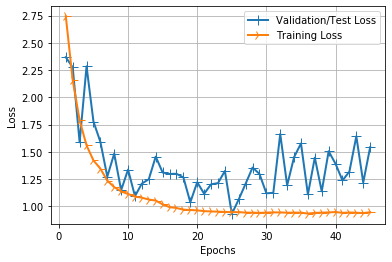

In [6]:
#Evaluating training and test error
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1, linewidth = 2.0, marker = '+', markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = '4', markersize = 10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

Found 2590 images belonging to 4 classes.
Confusion Matrix
[[338  22  60  71]
 [ 38 782  39  20]
 [151 159 176 140]
 [ 81  41 153 319]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.56      0.69      0.62       491
       Happy       0.78      0.89      0.83       879
     Neutral       0.41      0.28      0.33       626
         Sad       0.58      0.54      0.56       594

    accuracy                           0.62      2590
   macro avg       0.58      0.60      0.58      2590
weighted avg       0.60      0.62      0.61      2590



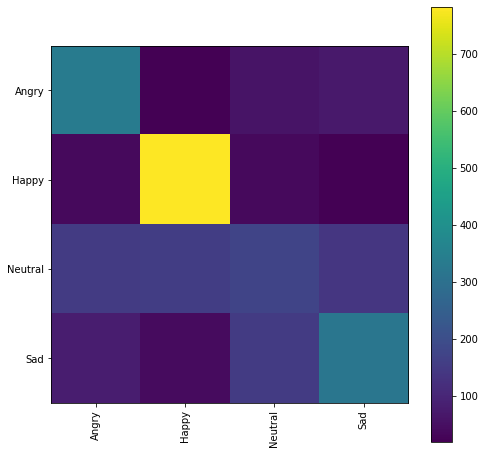

In [7]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 21975
nb_validation_samples = 2590

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size = (img_rows, img_cols),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names = target_names))

plt.figure(figsize = (8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation = 'nearest')

plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation = 90)
_ = plt.yticks(tick_marks, classes)

In [8]:
from keras.models import load_model

classifier = load_model('C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\face_emotion_LiteNet_ELU.h5')

In [9]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size = (img_rows, img_cols),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 2590 images belonging to 4 classes.
{0: 'Angry', 1: 'Happy', 2: 'Neutral', 3: 'Sad'}


In [10]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 300 ,cv2.BORDER_CONSTANT,value = BLACK)
    cv2.putText(expanded_image, "predited - "+ pred, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - "+ true_label, (20, 120) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)


def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height),grayscale = True), final_path, path_class

img_width, img_height = 48, 48

model.compile(loss = 'categorical_crossentropy',
              optimizer = keras.optimizers.Adam(lr = 0.001),
              metrics = ['accuracy'])

files = []
predictions = []
true_labels = []

#Predicting images
for i in range(0, 10):
    path = 'C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\validation\\' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis = 0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()

C:\Users\Admin\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [11]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\Haarcascades\\haarcascade_frontalface_default.xml')

def face_detector(img):
    #Convert image to greyscale
    gray = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []   
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x,w,y,h))
    return rects, allfaces, img

img = cv2.imread("C:\\Users\\Admin\\Desktop\\Research\\Datasets Used\\Face_Emotion\\Working Images\\2016-08-11 01.56.05 1-cropped.jpg")
rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    #Make a prediction on the ROI, then lookup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]   

    #Overlay our detected emotion on our pic
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0), 2)
    
cv2.imshow("Emotion Detector", image)
cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()  